### 참고링크
https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook

### tfrecord 파일 생성
* tfrecord 파일은 tensorflow의 학습 데이터 등을 저장하기 위한 바이너리 데이터 포맷
* 데이터 양이 많을 경우 이를 binary로 serialization한 뒤 파일 형태로 저장하고 있다가, 이를 다시 읽어들이는 형태로 처리하면 속도 상의 이득을 기대할 수 있음
* tfrecord 파일의 필요성
  1. csv 파일에서와 같이 숫자나 텍스트 데이터를 읽을 때는 크게 지장이 없지만, 이미지 데이터를 읽은 경우 이미지는 JPEG나 PNG 형태의 파일로 저장되어 있고 이에 대한 메타 데이터와 레이블은 별도의 파일에 저장되어 있기 때문에, 학습 데이터를 읽을 때 메타데이터나 레이블 파일 하나만 읽는 것이 아니라 이미지 파일도 별도로 읽어야 하기 때문에, 코드가 복잡해짐 
  2. 이미지를 JPG나 PNG 포맷으로 읽어서 매번 디코딩하게 되면, 그 성능이 저하되서 학습단계에서 데이터를 읽는 부분에서 많은 성능이 저하된다
* tfrecord 파일 생성은 기록하고자 하는 데이터의 feature들을 python dictionary 형태로 정의한 후에 데이터 하나씩 `tf.train.Example` 객체로 만들어, `tf.io.TFRecordWriter`를 통해서 파일로 저장함

In [ ]:
import tensorflow as tf

# 바이트 피처 함수
def bytes_feature(values):  
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

# int 피처 함수
def int64_feature(values):  
    if not isinstance(values, (tuple, list)):    
        values = [values]  
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))
    
# 이미지 파일 binary 형태 불러오는 함수
def read_imagebytes(imagefile):    
    file = open(imagefile,'rb')    
    bytes = file.read()    
    return bytes

def main():
    for i in tqdm(glob('C:/data1/data/*/*')):
        image_data = read_imagebytes(i) # 이미지 파일 binary 형태 정보
        label = int(i.split('\\')[1].split('_')[1]) # 데이터 라벨 정보
        tf_example = tf.train.Example(features=tf.train.Features(feature={		
        # feature 정보 입력      
        'image': bytes_feature(image_data),    
        'class': int64_feature([label]),
        }))	
        
        tmp = i.split('\\')[2].split('.')[0] # 파일명 정보
        writer = tf.io.TFRecordWriter(f'C:/Users/pmy49/OneDrive/바탕 화면/output/{str(label)}_{tmp}.tfrecord')	
        writer.write(tf_example.SerializeToString())
    
main()

### Cutmix 정의
 * Cutout + Mixup
 * 특정 부분을 떼와 두 이미지 간의 결합

### 필요한 모듈 불러오기

In [1]:
import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf, tensorflow.keras.backend as K
print('Tensorflow version ' + tf.__version__)
from sklearn.model_selection import KFold

Tensorflow version 2.10.0


### 분산 전략 수행

In [2]:
# 훈련을 여러 장치들로 분산시킴
# 장치의 수 : 1개
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # 분산 전략 수행

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


### 하이퍼파라미터 정의

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [96, 96]
EPOCHS = 25
FOLDS = 3
SEED = 777
BATCH_SIZE = 128
AUG_BATCH = BATCH_SIZE
FIRST_FOLD_ONLY = False

### 데이터 디렉토리와 클래스

In [4]:
TRAINING_FILENAMES = tf.io.gfile.glob('C:/Users/pmy49/OneDrive/바탕 화면/output/*.tfrecord')

In [5]:
CLASSES = ['L2_3', 'L2_10', 'L2_12', 'L2_15', 'L2_20',
           'L2_21', 'L2_24', 'L2_25', 'L2_27', 'L2_30',
           'L2_33', 'L2_34', 'L2_39', 'L2_40', 'L2_41',
           'L2_44', 'L2_45', 'L2_46', 'L2_50', 'L2_52']

### 학습률 스케줄링
 * 알고리즘의 목적함수를 optimizing할 때, 경사하강법 기반의 최적화 알고리즘을 적용하는 경우, 학습률을 결정함에 있어 고정된 하나의 값으로 학습률을 사용하지 않고 학습 반복이 진행됨에 따라 미리 정해놓은 스케줄대로 학습률을 변경하는 전략
 * 학습 초기에는 큰 학습률로 시작해서 epoch이 진행됨에 따라 점차 줄이는 것

Learning rate schedule: 1e-05 to 5e-05 to 1.06e-05


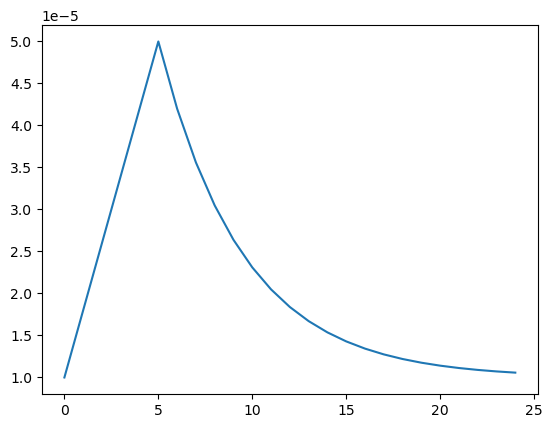

In [6]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

### 데이터셋 함수

In [7]:
# 이미지 디코딩 함수
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# 라벨 O
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

# 라벨 x
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

# 데이터셋 불러오기
def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

# 데이터 증식하기 (일정 확률로 좌우로 뒤집음)
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset, do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(AUG_BATCH)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO) # note we put AFTER batching
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # 모델이 훈련하는동안 데이터셋이 백그라운드에서 배치들을 가져올 수 있게 함
    return dataset

def get_validation_dataset(dataset, do_onehot=True):
    dataset = dataset.batch(BATCH_SIZE)
    if do_onehot: dataset = dataset.map(onehot, num_parallel_calls=AUTO) # we must use one hot like augmented train data
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# def get_test_dataset(ordered=False):
#     dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
#     dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
#     return dataset

# def count_data_items(filenames):
#     # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
#     n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
#     return np.sum(n)

# NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
# NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
# NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
# STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

# print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

### Cutmix

In [8]:
def onehot(image,label):
    CLASSES = 20
    return image,tf.one_hot(label,CLASSES)

In [9]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 20
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CUTMIX할 이미지 index 뽑기
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CUTMIX할 위치 뽑기
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        # CUTMIX할 너비 및 높이
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        # CUTMIX에서의 X, Y의 범위
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # CUTMIX 이미지 만들기
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # CUTMIX 라벨 만들기
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # 이미지와 라벨 정보 쌓기
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

### Display CutMix Augmentation

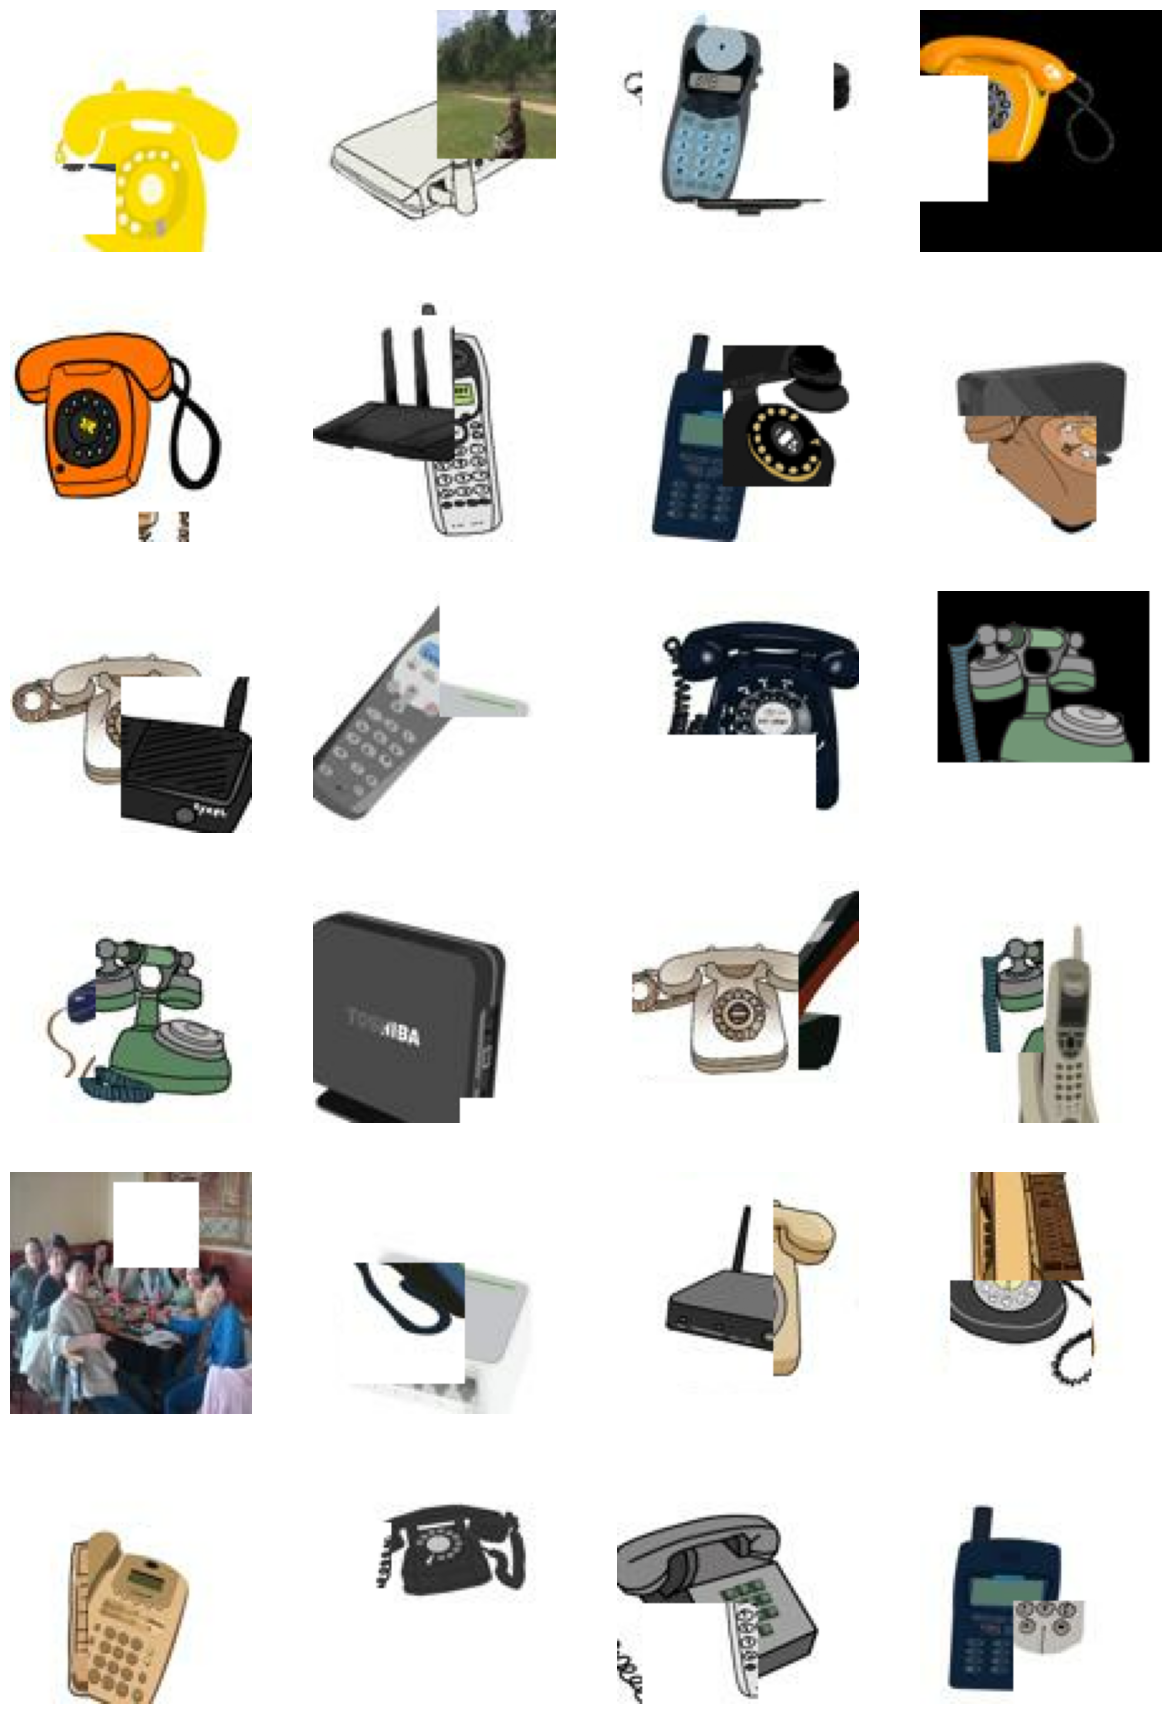

In [10]:
row = 6; col = 4
row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(cutmix)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break